In [1]:
import os
import json
from model_functions import PaddedDataset, trainer_gpt2_transformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import GPT2Config, GPT2Tokenizer, GPT2LMHeadModel, DataCollatorForLanguageModeling, TrainingArguments, Trainer


PATH_VOCAB = "../0_data/5_vocabs"
PATH_WORD_DATA = "../0_data/6_word_data"
PATH_MODELS = "../0_data/7_models"
PATH_MODELS_LOSS = "../0_data/7_models/loss"
PATH_MODELS_CONFIG = "../0_data/7_models/config"

for path in [PATH_MODELS, PATH_MODELS_LOSS, PATH_MODELS_CONFIG]:
    if not os.path.exists(path):
        os.makedirs(path)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
model_df = pd.read_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx", index_col="Unnamed: 0")
model_df

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1_50,1024,256,4,6,0,0.001,50,4,yes,633.0726,10.55,1.341614,33.0,400.472565,NaN,NaN,NaN
1,a2_50,1024,256,4,6,0,0.001,50,4,yes,660.1042,11.00,1.133472,41.0,206.331863,NaN,NaN,NaN
2,a3_50,1024,256,4,6,0,0.001,50,4,yes,636.4971,10.61,1.348449,36.0,167.751266,NaN,NaN,NaN
3,b_50,1024,256,4,6,0,0.001,50,4,yes,636.4864,10.61,1.349513,36.0,254.352493,NaN,NaN,NaN
4,c_50,1024,256,4,6,0,0.001,50,4,yes,669.2868,11.15,1.340456,36.0,163.397003,NaN,NaN,NaN
5,d_50,1024,256,4,6,0,0.001,50,4,yes,655.0100,10.92,1.167735,50.0,486.180145,NaN,NaN,NaN
6,a1,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,a2,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,a3,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,b,1024,256,4,6,0,0.001,20,4,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.448100,2.149122
2,2.097400,2.089386
3,2.056000,2.079797
4,2.027600,2.043489
5,1.993600,1.998908
6,1.944500,1.879207
7,1.719000,1.581352
8,1.548600,1.481426
9,1.492900,1.446772
10,1.464100,1.422052


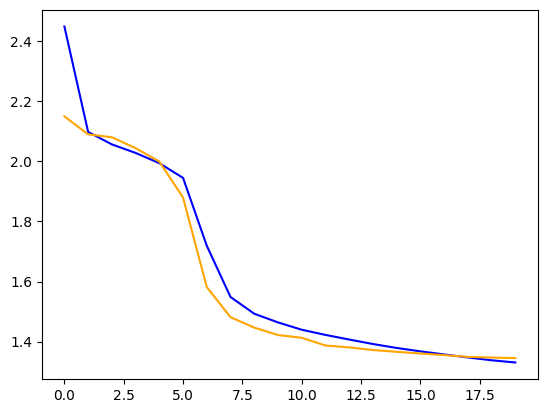

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.246400,1.984720
2,1.880900,1.872455
3,1.825600,1.846977
4,1.806900,1.841085
5,1.781700,1.817309
6,1.758900,1.809640
7,1.741600,1.794507
8,1.725100,1.779767
9,1.706700,1.761073
10,1.648900,1.593466


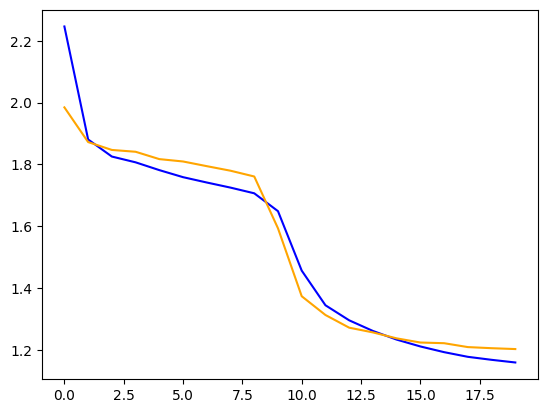

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.373900,2.134140
2,2.083200,2.092139
3,2.042300,2.056114
4,2.011900,2.035990
5,1.977000,1.969758
6,1.841700,1.671894
7,1.611300,1.543524
8,1.536700,1.491018
9,1.500000,1.473780
10,1.475300,1.447582


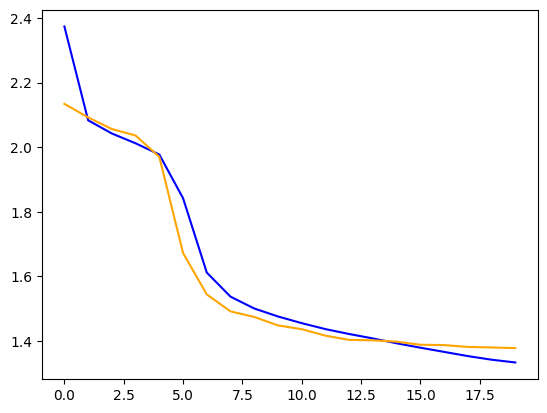

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.467300,2.151914
2,2.097700,2.110307
3,2.055700,2.059713
4,2.025700,2.056029
5,1.991800,1.983956
6,1.867700,1.693143
7,1.613000,1.521174
8,1.523400,1.481514
9,1.490100,1.442473
10,1.465500,1.429181


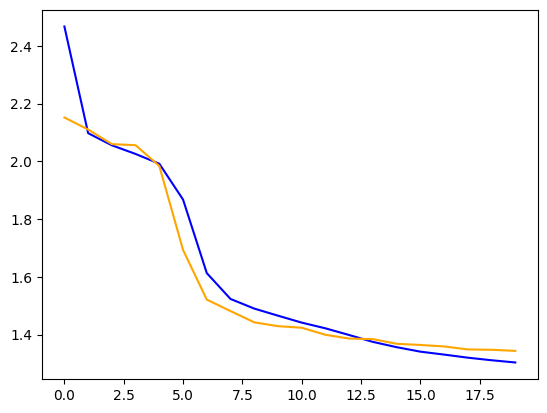

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.348800,2.130652
2,2.084300,2.079236
3,2.041100,2.060200
4,2.011200,2.039494
5,1.982200,1.982672
6,1.900500,1.731645
7,1.602600,1.496810
8,1.481200,1.455779
9,1.434100,1.424612
10,1.407200,1.409461


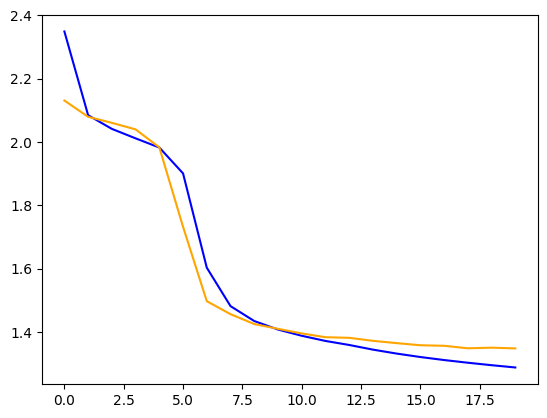

/home/jlauten_ext/PyEnv/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.164000,1.935570
2,1.857800,1.866910
3,1.820600,1.870092
4,1.802200,1.844536
5,1.780000,1.815805
6,1.758000,1.814837
7,1.739100,1.798230
8,1.708800,1.718688
9,1.554400,1.415589
10,1.377000,1.339127


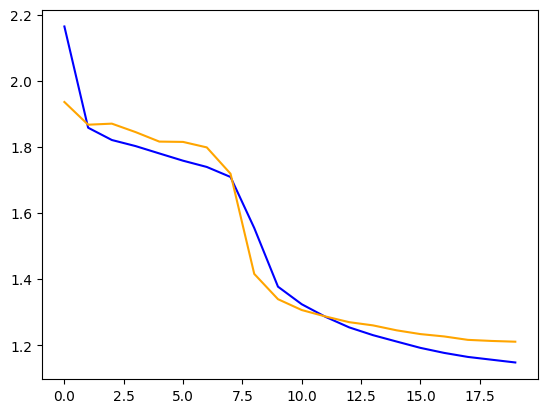

,name,max_length,emb_dim,attention_heads,layers,dropout,learning_rate,epochs,batch_size,ran,runtime,runtime_min,min_loss,at_epoch,perplexity,incorrect_notes,correct_notes,correct_rate
0,a1_50,1024,256,4,6,0,0.001,50,4,yes,633.0726,10.55,1.341614,33.0,400.472565,NaN,NaN,NaN
1,a2_50,1024,256,4,6,0,0.001,50,4,yes,660.1042,11.00,1.133472,41.0,206.331863,NaN,NaN,NaN
2,a3_50,1024,256,4,6,0,0.001,50,4,yes,636.4971,10.61,1.348449,36.0,167.751266,NaN,NaN,NaN
3,b_50,1024,256,4,6,0,0.001,50,4,yes,636.4864,10.61,1.349513,36.0,254.352493,NaN,NaN,NaN
4,c_50,1024,256,4,6,0,0.001,50,4,yes,669.2868,11.15,1.340456,36.0,163.397003,NaN,NaN,NaN
5,d_50,1024,256,4,6,0,0.001,50,4,yes,655.0100,10.92,1.167735,50.0,486.180145,NaN,NaN,NaN
6,a1,1024,256,4,6,0,0.001,20,4,yes,265.2580,4.42,1.345365,20.0,137.914551,NaN,NaN,NaN
7,a2,1024,256,4,6,0,0.001,20,4,yes,260.7209,4.35,1.202786,20.0,120.460831,NaN,NaN,NaN
8,a3,1024,256,4,6,0,0.001,20,4,yes,262.6342,4.38,1.377196,20.0,177.487762,NaN,NaN,NaN
9,b,1024,256,4,6,0,0.001,20,4,yes,265.6575,4.43,1.343577,20.0,188.348267,NaN,NaN,NaN


In [5]:
rows = []

for index, row in model_df.iterrows():
    
    # only run models that not ran yet
    if row["ran"] == "yes":
        continue
    
    # create model name directories
    model_name = row["name"]
    model_dirs = {
        "loss": f"{PATH_MODELS_LOSS}/{model_name}",
        "out": f"{PATH_MODELS_CONFIG}/{model_name}"
    }
    for key in model_dirs:
        if not os.path.exists(model_dirs[key]):
            os.makedirs(model_dirs[key])
    
    # save hyperparameters as dictionary
    model_hyperparameters = {
        "max_length": row["max_length"],
        "emb_dim": row["emb_dim"],
        "attention_heads": row["attention_heads"],
        "layers": row["layers"],
        "dropout": row["dropout"],
        "learning_rate": row["learning_rate"],
        "epochs": row["epochs"],
        "batch_size": row["batch_size"],
    }
    
    # create tokenizer
    tokenizer = GPT2Tokenizer(
        vocab_file=f"{PATH_VOCAB}/vocab_{model_name}.json", 
        merges_file=f"{PATH_VOCAB}/merges.txt")
    tokenizer.add_special_tokens({'pad_token': 'PAD', 'bos_token': 'BOS', 'eos_token': 'EOS',})
    
    # read in data
    with open(f"{PATH_WORD_DATA}/{model_name}_data.json", 'r') as fp:
        json_data = json.load(fp)
    song_list = []
    for song in json_data:
        song_list.append(json_data[song])
    data = [" ".join(song) for song in song_list]
    split_train_test = int(0.9*len(data))
    
    # create datasets and define data collator
    train_dataset = PaddedDataset(tokenizer=tokenizer, data=data[:split_train_test], max_length=row["max_length"])
    eval_dataset = PaddedDataset(tokenizer=tokenizer, data=data[split_train_test:], max_length=row["max_length"])
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
    model_data = {
        "train_dataset": train_dataset,
        "eval_dataset": eval_dataset,
        "data_collator": data_collator,
    }
    
    # create and train model trainer
    trainer = trainer_gpt2_transformer(
        hyperparameters = model_hyperparameters,
        tokenizer = tokenizer,
        data = model_data,
        dirs = model_dirs,
    )
    trainer.train()
    
    # compute perplexity
    inputs = tokenizer.encode("Bar_None".split(" "), return_tensors="pt")
    outputs = trainer.predict(tokenizer.encode("Bar_None".split(" "), return_tensors="pt"))
    logits = outputs.predictions
    probabilities = torch.softmax(torch.from_numpy(logits), dim=-1)
    log_probabilities = torch.log(probabilities)
    num_samples = log_probabilities.size(1)
    total_log_prob = torch.sum(log_probabilities[0, torch.arange(num_samples), inputs[0]])
    perplexity = torch.exp(-total_log_prob / num_samples).item()
    
    # save runtime and model loss
    log_hist = trainer.state.log_history
    eval_loss = [log_hist[i]["eval_loss"] for i in range(1,len(log_hist),2)]
    train_loss = [log_hist[i]["loss"] for i in range(0,len(log_hist)-1,2)]
    runtime = log_hist[-1]["train_runtime"]
    
    model_df.at[index,"perplexity"] = perplexity
    model_df.at[index,"runtime"] = runtime
    model_df.at[index,"runtime_min"] = (runtime/60).__round__(2)
    model_df.at[index,"min_loss"] = min(eval_loss)
    model_df.at[index,"at_epoch"] = np.argmin(eval_loss) + 1

    # show loss plot
    plt.plot(train_loss, color="blue")
    plt.plot(eval_loss, color="orange")
    plt.savefig(f"{model_dirs['loss']}/loss_graph_{model_name}.jpg")
    plt.show()
    
    # save model and set ran to yes
    trainer.save_model(f"{model_dirs['out']}/end_version")
    model_df.at[index,"ran"] = "yes"
    
model_df

In [6]:
model_df.to_excel(f"{PATH_MODELS}/comparison_model_stats.xlsx")